In [1]:
import argparse
import math
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import scipy.io
import imageio.v3 as iio
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares
from scipy.signal import savgol_filter
from skimage.feature import canny
from tqdm import tqdm
from vedo import Line, Plotter, Volume, show
from scipy.spatial.distance import cdist
from skimage import exposure
from scipy.interpolate import splprep, splev
from scipy.optimize import minimize

from skimage.metrics import structural_similarity as compare_ssim
import torch
import time
from datetime import timedelta

from core.tools import save_png
from core.visualize import *
from model.oral_3d import Oral3D
from preprocess.arch_estimate import estimate_trajectory_by_dental_arch
from preprocess.cbct_utils import *
from preprocess.pre_defined_trajectories import estimate_trajectory_by_beta_function
from preprocess.utils import get_MPR_images_from_projection_rays, get_projection_image_from_MPR_images
from preprocess.utils import *
from projection.basic import Point
from projection.projection_ray import ProjectionRay
from projection.trajectory import Trajectory
from utils.eval import get_psnr, get_dice
from utils.ssim import SSIM

CANNY_LOW = 100
CANNY_HIGH = 200


In [2]:
def load_all_control_points(mat_dir, ctrl_key='SplineCtrlPoints', n_ctrl_pts_expected=20):
    """
    Carica tutti i punti di controllo validi dai file .mat in una directory.

    Returns:
        all_ctrl_points (list of np.ndarray): Lista di array (20, 2)
        case_names (list of str): Nomi dei file .mat caricati correttamente
    """
    all_ctrl_points = []
    case_names = []

    for fname in os.listdir(mat_dir):
        if not fname.endswith('.mat'):
            continue
        data = scipy.io.loadmat(os.path.join(mat_dir, fname))
        if ctrl_key not in data:
            continue

        ctrl_pts = np.array(data[ctrl_key])
        if ctrl_pts.shape[1] != 2:
            ctrl_pts = ctrl_pts.T

        if ctrl_pts.shape[0] != n_ctrl_pts_expected:
            continue

        all_ctrl_points.append(ctrl_pts)
        case_names.append(fname)

    return all_ctrl_points, case_names

def compute_average_curve(all_ctrl_points, n_prior_pts=576):
    """
    Calcola la curva spline media a partire da un insieme di punti di controllo.

    Parametri:
    - all_ctrl_points: array di forma (N, M, 2), dove N = numero di casi, M = numero di punti di controllo.
    - n_prior_pts: numero di punti della curva interpolata finale (default: 576).

    Ritorna:
    - avg_ctrl_points: array di forma (M, 2), punti di controllo medi.
    - prior_shape: array di forma (n_prior_pts, 2), curva spline interpolata.
    """

    # === Calcola media su X e Y ===
    all_ctrl_points = np.array(all_ctrl_points)  # (N, 20, 2)
    avg_ctrl_points = np.mean(all_ctrl_points, axis=0)  # (20, 2) 
    x_avg, y_avg = avg_ctrl_points[:, 0], avg_ctrl_points[:, 1]

    # Costruisci la spline e genera la curva
    spline = CubicSpline(x_avg, y_avg, bc_type='natural')
    x_prior = np.linspace(x_avg.min(), x_avg.max(), n_prior_pts)
    y_prior = spline(x_prior)
    prior_shape = np.stack((x_prior, y_prior), axis=1)

    return avg_ctrl_points, prior_shape

def plot_and_save_average_with_outliers(avg_ctrl_points, prior_shape, all_ctrl_points, case_names, output_path='avg_curve.mat', top_n=5):
    """
    Salva i risultati medi in .mat, visualizza graficamente tutte le curve e stampa i casi più distanti dalla media.

    Args:
        avg_ctrl_points: array (20, 2)
        prior_shape: array (576, 2)
        all_ctrl_points: lista di curve originali (N, 20, 2)
        case_names: lista di nomi file (N)
        output_path: nome file per salvare .mat
        top_n: numero di outlier da mostrare
    """

    # === Salva curva media e spline in .mat ===
    scipy.io.savemat(output_path, {
        'AvgSplineCtrlPoints': avg_ctrl_points,
        'AvgPriorShape': prior_shape
    })

    # === Calcola distanza RMSE tra ogni curva e la media ===
    all_ctrl_points = np.array(all_ctrl_points)
    errors = np.sqrt(np.mean((all_ctrl_points - avg_ctrl_points[None, :, :])**2, axis=(1, 2)))

    # === Ordina per distanza decrescente ===
    sorted_idx = np.argsort(errors)[::-1]
    worst_cases = [(case_names[i], errors[i]) for i in sorted_idx[:top_n]]

    # === Plot ===
    plt.figure(figsize=(6, 5))
    for i, curve in enumerate(all_ctrl_points):
        color = 'red' if i in sorted_idx[:top_n] else 'gray'
        alpha = 0.8 if i in sorted_idx[:top_n] else 0.3
        plt.plot(curve[:, 0], curve[:, 1], color=color, alpha=alpha)

    plt.plot(avg_ctrl_points[:, 0], avg_ctrl_points[:, 1], 'bo-', label='Media X+Y')
    plt.plot(prior_shape[:, 0], prior_shape[:, 1], 'r--', label='Spline su 576 punti')
    plt.title("Spline media e curve originali")
    plt.xlabel("X (voxel)")
    plt.ylabel("Y (voxel)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Stampa outlier ===
    #print(f"\n[INFO] Top {top_n} curve più distanti dalla media:")
    #for fname, err in worst_cases:
    #    print(f"  {fname:<40} RMSE = {err:.2f}")


    #df = pd.DataFrame(avg_ctrl_points, columns=["x", "y"])
    #df.to_csv("avg_ctrl_points.csv", index=False)
    #print("\nPunti di controllo medi:")
    #print(df)
    
def save_nii(volume, affine_matrix, file_name, save_dir):
    nii_img = nib.Nifti1Image(volume, affine_matrix)
    os.makedirs(save_dir, exist_ok=True)
    nib.save(nii_img, os.path.join(save_dir, file_name))

def get_distance_to_curve(point, curve_pts):
    dists = np.linalg.norm(curve_pts - point, axis=1)
    min_idx = np.argmin(dists)
    sign = 1 if point[1] > curve_pts[min_idx, 1] else -1
    return min_idx, int(sign * dists[min_idx])

def interpolate_cbct(mpr, sample_pts):
    cbct = np.ones((288, 256, 160), dtype=np.float64) * -1
    for x in range(288):      
        for y in range(256):   
            min_id, dist = get_distance_to_curve(np.array([x, y]), sample_pts)
            slice_idy = dist + 40  # offset per centrare l'immagine
        # il volume viene riempito colonna per colonna, 
        # andando a recuperare valori lungo Z da MPR
            if 0 <= slice_idy < mpr.shape[1] and 0 <= min_id < mpr.shape[0]:
                #cbct[x, y, :] = mpr[min_id, slice_idy, :]  
                cbct[x, y, :] = mpr[min_id, mpr.shape[1] - 1 - slice_idy, :]

    return cbct

def interpolate_spline_from_control_points(control_points, num_points=576):
    x_ctrl, y_ctrl = control_points[:, 0], control_points[:, 1]
    tck, _ = splprep([x_ctrl, y_ctrl], s=0, k=min(3, len(control_points) - 1)) 
    u_interp = np.linspace(0, 1, num_points) 
    x_interp, y_interp = splev(u_interp, tck)
    return np.stack([x_interp, y_interp], axis=1)

def reduce_to_control_points(prior_shape, num_ctrl_pts=10):
    x, y = prior_shape[:, 0], prior_shape[:, 1] 
    tck, _ = splprep([x, y], s=0)   
    u_fine = np.linspace(0, 1, num_ctrl_pts) 
    x_new, y_new = splev(u_fine, tck) 
    return np.stack([x_new, y_new], axis=1) 

def auto_canny(image, sigma=0.33):
    """
    Applica Canny edge detection con soglie automatiche basate sul contrasto locale.
    - image: immagine in scala di grigi (può essere float o uint8)
    - sigma: parametro per controllare la sensibilità (default 0.33)
    """
    if image.dtype != np.uint8:
        image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
    
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

def normalized_cross_correlation(im1, im2):
    im1 = (im1 - np.mean(im1)) / (np.std(im1) + 1e-8)   
    im2 = (im2 - np.mean(im2)) / (np.std(im2) + 1e-8)
    return np.mean(im1 * im2)

def to_uint8(image):
    image = np.nan_to_num(image)
    norm = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    return (norm * 255).astype(np.uint8)

def show_edge_comparison(px_sim, px_real, title='Edge comparison'):
    px_sim_uint8 = to_uint8(px_sim)
    px_real_uint8 = to_uint8(px_real)

    edge_sim = cv2.Canny(px_sim_uint8, CANNY_LOW, CANNY_HIGH)
    edge_real = cv2.Canny(px_real_uint8, CANNY_LOW, CANNY_HIGH)

    # Binarizza le edge maps
    edge_sim_bin = (edge_sim > 0).astype(np.uint8)
    edge_real_bin = (edge_real > 0).astype(np.uint8)

    # Calcola il Dice coefficient
    dice = get_dice(edge_sim_bin, edge_real_bin)

    # Visualizza
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))
    axs[0].imshow(edge_real, cmap='gray', origin='lower')
    axs[0].set_title("Edge PX Reale")
    axs[1].imshow(edge_sim, cmap='gray', origin='lower')
    axs[1].set_title("Edge PX Sintetica")
    plt.suptitle(f"{title}\nDice = {dice:.4f}")
    plt.show()

    print(f"[INFO] Dice = {dice:.4f}")
    return dice

def show_weighted_area_on_px(px_image, title="Zona pesata per ottimizzazione"):
    plt.figure(figsize=(8, 4))
    plt.imshow(px_image, cmap='gray', origin='lower')
    plt.title(title)
    plt.axis("off")

    # Aggiungi rettangolo: (x, y, larghezza, altezza)
    rect = patches.Rectangle(
        (80, 30),         # (x=start_col, y=start_row)
        400,               # larghezza = 350 - 200
        90,                # altezza = 120 - 30
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    plt.gca().add_patch(rect)
    plt.show()

def get_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = np.max(img2)  # oppure 1.0 se già normalizzate
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def get_ssim(img1, img2):
    # img1 e img2 devono essere [H, W, D] oppure 2D slice-by-slice
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    ssim_total = 0
    count = 0
    for i in range(img1.shape[0]):
        ssim_slice = compare_ssim(img1[i], img2[i], data_range=img2[i].max() - img2[i].min())
        ssim_total += ssim_slice
        count += 1
    return ssim_total / count

def get_dice(pred, target):
    intersection = np.sum(pred * target)
    return 2.0 * intersection / (np.sum(pred) + np.sum(target) + 1e-8)

def convert_to_oral_3d_px(px_img):
    mean = np.mean(px_img)
    std = np.std(px_img)
    threshold = 4
    px_img = (px_img - mean)/std
    px_img[px_img > threshold] = threshold
    px_img[px_img < -threshold] = -threshold
    
    px_img = (px_img - np.min(px_img))/(np.max(px_img) - np.min(px_img)) * 255
    return np.array(px_img, dtype=np.uint8)

def apply_raytracing_params(spline_curve, cbct_volume, tx=0.0, ty=0.0, angle_deg=0.0, proj_dist=60.0, scale=1.0):
    trajectory, _ = estimate_trajectory_by_dental_arch(cbct_volume, spline_curve)

    rays = []
    angle_rad = np.deg2rad(angle_deg)
    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])

    for ray in trajectory.sample_projection_rays(sample_n=576, ray_length=100):
        # Trasforma il centro del raggio
        pt = np.array([ray.center.x, ray.center.y])
        scaled = pt * scale
        rotated = R @ scaled                 # ruota il punto di partenza di un raggio
        transformed = rotated + np.array([tx, ty])
        ray.center.x = transformed[0]
        ray.center.y = transformed[1]

        ray.theta += angle_rad    # ruota il vettore direzionale del raggio

        rays.append(ray)


    mpr = get_MPR_images_from_projection_rays(rays, cbct_volume, projection_distance=proj_dist)
    px_sim = get_projection_image_from_MPR_images(mpr)

    return px_sim.T  

def show_single_projection(spline_curve, cbct_volume, tx=0.0, ty=0.0, angle_deg=0.0,
                           scale=1.0, proj_dist=60.0, title=None):
    px_sim = apply_raytracing_params(spline_curve, cbct_volume, tx=tx, ty=ty,
        angle_deg=angle_deg, scale=scale, proj_dist=proj_dist)

    plt.figure(figsize=(8, 6))
    plt.imshow(px_sim, cmap='gray')
    plt.title(title or f"TX={tx}, TY={ty}, Angle={angle_deg}°, Scale={scale}, Dist={proj_dist}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Calcola la curva di regressione media

In [3]:
#all_ctrl_points, case_names = load_all_control_points(mat_dir)
#avg_ctrl_points, prior_shape = compute_average_curve(all_ctrl_points, n_prior_pts=576)
#plot_and_save_average_with_outliers(avg_ctrl_points, prior_shape, all_ctrl_points, case_names)

In [4]:
case_id = 1
device = 'cuda:0'
mat_dir = r'C:\Users\angel\Desktop\tesi-git\preprocessing\data\mat_oral_3d'
ckpt_path = r'C:\Users\angel\Desktop\tesi-git\output\Oral_3D_MPR\ckpt\model_best.pth.tar'

avg_curve_mat = './avg_curve.mat'
px_path = f"./case_{case_id:03d}_px.png"
mat_path = f"./output_GENERATED/case_{case_id:03d}_generated.mat"
base_path = f'C:/Users/angel/Desktop/tesi-git/preprocessing/data/mat_oral_3d/case_{case_id:03d}.mat'
output_dir = "./output_GENERATED"



Partiamo dall px reale e dalla curva media e cominciamo il ciclo di ottimizzazione

In [5]:
# === 1. Carica la panoramica reale ===
#px_real = iio.imread(px_path).astype(np.float32)
#px_real = np.flipud(px_real)  # origin='lower' coerente con ray tracing
px_real = scipy.io.loadmat(base_path)['Ideal_PX']
cbct_true = scipy.io.loadmat(base_path)['CBCT']

#px_real = np.swapaxes(px_real, 0, 1).T
#np.swapaxes(np.array(convert_to_oral_3d_px(projection_image), dtype=np.float32), 0, 1),
# === 2. Carica la curva media appena calcolata ===
avg_data = scipy.io.loadmat(avg_curve_mat)
prior_shape = avg_data['AvgPriorShape']
ctrl_points = avg_data['AvgSplineCtrlPoints']


# === 3. Salva file .mat per questo caso ===
data_gen = {
    #'Real_PX':px_real,
    'PriorShape': prior_shape,
    'AvgSplineCtrlPoints': ctrl_points,
	'Case_ID': case_id
}
os.makedirs(os.path.dirname(mat_path), exist_ok=True)
scipy.io.savemat(mat_path, data_gen)
print(f"[INFO] Salvato: {mat_path}")

#data = scipy.io.loadmat(mat_path)
#px_real_mat = data['Real_PX']


[INFO] Salvato: ./output_GENERATED/case_001_generated.mat


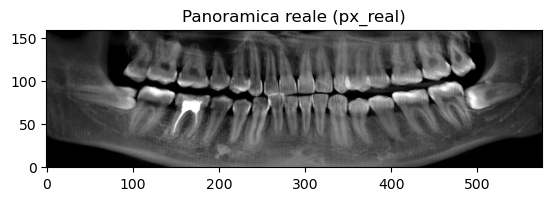

In [6]:
plt.imshow(scipy.io.loadmat(base_path)['Ideal_PX'], cmap='gray',origin='lower')  # prova anche 'upper' se serve
plt.title("Panoramica reale (px_real)")
plt.axis('on')
plt.show()

In [7]:
# === 4. Converti la panoramica in tensore PyTorch ===
px_tensor = torch.tensor(scipy.io.loadmat(base_path)['Ideal_PX'], dtype=torch.float, device=device)
px_tensor = px_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, H, W)
px_tensor.shape

torch.Size([1, 1, 160, 576])

In [8]:
model = Oral3D(device=device)
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict']) 
model.to(device)
model.eval()
print(f"[INFO] Modello Oral3D caricato da: {ckpt_path}")

[INFO] Modello Oral3D caricato da: C:\Users\angel\Desktop\tesi-git\output\Oral_3D_MPR\ckpt\model_best.pth.tar


[INFO] Generazione volume ricostruito MPR per il caso 1...
(80, 160, 576)
[INFO] Volume MPR generato salvato come: MPR_case_001.nii.gz
[INFO] File .mat aggiornato in: ./output_GENERATED/case_001_generated.mat


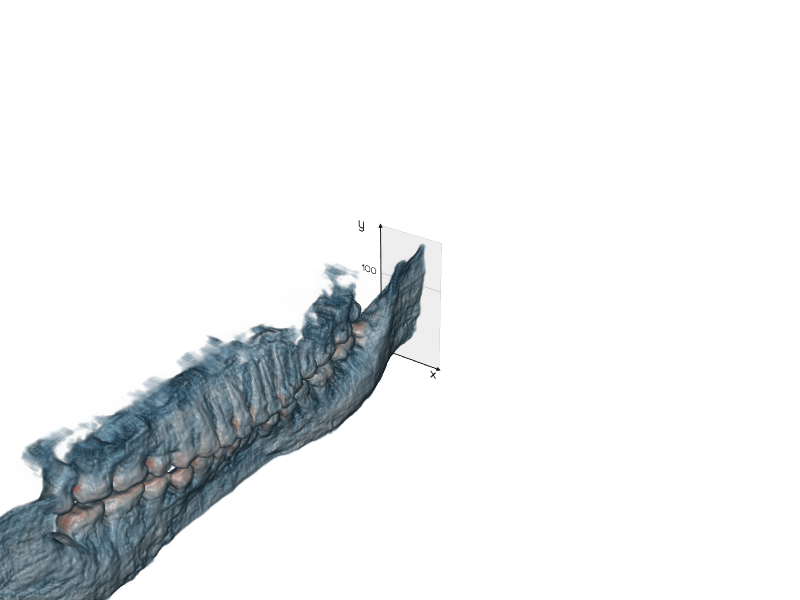

In [9]:
print(f"[INFO] Generazione volume ricostruito MPR per il caso {case_id}...")
with torch.no_grad():
    
    generation = model.generate(px_tensor, VAL=False)
    generation_np = generation.squeeze().cpu().numpy() 
    #generation_np = np.array((generation_np + 1) * 2000, dtype=np.uint16)
 
    #generation_np = np.transpose(generation_np, (2, 0, 1)) 
    #generation_np = rotate(generation_np, 180, axes=(1, 0), reshape=False)
#generation_np = np.flip(generation_np, axis=2)  # flip lungo asse larghezza

print(generation_np.shape)

mpr_filename = f"MPR_case_{case_id:03d}.nii.gz"
identity_affine = np.eye(4, dtype=np.float32)
save_nii(generation_np, identity_affine, mpr_filename, output_dir)

print(f"[INFO] Volume MPR generato salvato come: {mpr_filename}")
data_gen['MPR_GENERATED'] = generation_np
scipy.io.savemat(mat_path, data_gen)
print(f"[INFO] File .mat aggiornato in: {mat_path}")


vol = Volume(generation_np, spacing=(1, 1, 1))
show(vol, axes=1, viewup='y', interactive=True)

contributi alla funzione di perdita per l'ottimizzazione dei punti di controllo della curva:
1. quanto gli edge corrispondono (dando maggiore importante alla forma delle strutture dentali)
2. NCC    (da capir emeglio non considerarlo qui, piuttosto per il ray tracing) 


In [ ]:
ncc_history = []
loss_history = []
edge_loss_history = [] 
ncc_loss_history = []   

def plot_loss_components(edge_loss, ncc_loss, total_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(edge_loss, label="Edge Loss (weighted)", color='orange')
    plt.plot(ncc_loss, label="NCC Loss (1 - NCC)", color='blue')
    plt.plot(total_loss, label="Total Combined Loss", color='red', linestyle='--')
    plt.xlabel("Step di ottimizzazione")
    plt.ylabel("Valore della Loss")
    plt.title("Contributi alla Loss durante l'Ottimizzazione")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
def residuals_function(ctrl_pts_flat, mpr_volume, px_real):
    global optimization_step_counter
    optimization_step_counter += 1

    ctrl_pts = ctrl_pts_flat.reshape(-1, 2)
    spline_curve = interpolate_spline_from_control_points(ctrl_pts, num_points=576)

    cbct_volume = interpolate_cbct(generation_np, spline_curve)
    
    trajectory, _ = estimate_trajectory_by_dental_arch(cbct_volume, spline_curve)
    projection_lines = trajectory.sample_projection_rays(sample_n=576, ray_length=100)
    MPR_images = get_MPR_images_from_projection_rays(projection_lines,cbct_volume ,projection_distance=60)
    #MPR_images = rotate(MPR_images, 180, axes=(1, 0), reshape=False)

    px_sim = get_projection_image_from_MPR_images(MPR_images).T

    px_sim_uint8 = to_uint8(px_sim)
    px_real_uint8 = to_uint8(px_real)
    edge_sim = cv2.Canny(px_sim_uint8, CANNY_LOW, CANNY_HIGH).astype(np.float32)
    edge_real = cv2.Canny(px_real_uint8, CANNY_LOW, CANNY_HIGH).astype(np.float32)
# Le differenze tra i bordi delle immagini vengono amplificate (triplicate) nella zona centrale dell’arcata dentale, tramite una maschera di pesi 
    edge_residual = edge_sim - edge_real 
    weights = np.ones((160, 576))        
    weights[30:120, 80:480] = 3.0       

    weighted_edge_residual = (weights * edge_residual).flatten()  # Applica i pesi al residuo dei bordi e lo appiattisce per passarlo a least_squares

    ncc_score = normalized_cross_correlation(px_sim, px_real)     # somiglianza  
    ncc_residual = np.ones_like(weighted_edge_residual) * (1 - ncc_score)  
    alpha = 0.7 
    combined_residual = alpha * weighted_edge_residual + (1 - alpha) * ncc_residual

    loss_edge = np.mean(np.abs(weighted_edge_residual))
    loss_ncc = np.mean(np.abs(ncc_residual))
    combined_residual = alpha * weighted_edge_residual + (1 - alpha) * ncc_residual
    total_loss = np.mean(np.abs(combined_residual))
    print(f"[INFO] Step {optimization_step_counter}: Total Loss = {total_loss:.4f}, NCC = {ncc_score:.4f}, EdgeLoss = {loss_edge:.4f}")

    ncc_history.append(ncc_score)
    loss_history.append(total_loss)
    edge_loss_history.append(loss_edge)
    ncc_loss_history.append(loss_ncc)

    return combined_residual

Ottimizzare la forma della curva spline mandibolare intervenendo sui suoi punti di controllo, in modo che la panoramica simulata (PX_sim) assomigli il più possibile alla panoramica reale (PX_real).
La curva modifica la traiettoria lungo cui i raggi attraversano il volume, quindi se cambia la forma della curva → cambia la struttura ossea "proiettata" nella panoramica sintetizzata.
Cambiare la forma della curva significa intervenire sulla geometria anatomica (forma della mandibola) nella PX: sarà più "stretta", più "larga", più "aperta", ecc

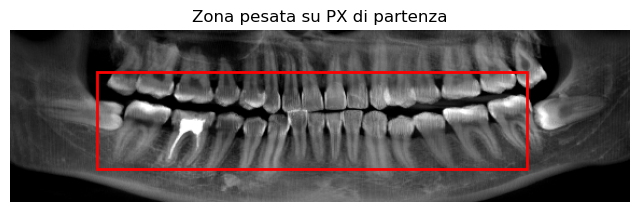

[INFO] Inizializzazione dei punti di controllo: [ 34.31999969 202.52404785  52.90033741 164.17376812  78.05672392
 129.65899355  98.17689028  91.96847221 126.27552339  60.90531444
 167.84319849  59.79034844 197.82141029  89.13518455 216.82197692
 127.40016409 241.90181785 161.91777585 255.         199.9210968 ]
(20,)
[INFO] Inizio ottimizzazione con 20 parametri...


In [11]:
control_points_init = reduce_to_control_points(prior_shape, num_ctrl_pts=10)
params_init = control_points_init.flatten()

n = len(params_init) // 2
lower_bounds = np.array([0] * n + [0] * n)
upper_bounds = np.array([287] * n + [255] * n)

x_coords = np.clip(params_init[:n], 0, 287)
y_coords = np.clip(params_init[n:], 0, 255)
params_init = np.concatenate([x_coords, y_coords])
show_weighted_area_on_px(px_real, title="Zona pesata su PX di partenza")
print(f"[INFO] Inizializzazione dei punti di controllo: {params_init}")
print(params_init.shape)
print(f"[INFO] Inizio ottimizzazione con {len(params_init)} parametri...")

In [12]:
optimization_step_counter = 0

In [13]:

print(f"[DEBUG] mpr.shape = {generation_np.shape}")  
#  [DEBUG] mpr.shape = (80, 160, 576)   non va bene   ma vuole [DEBUG] mpr.shape = (576, 80, 160)


[DEBUG] mpr.shape = (80, 160, 576)


In [14]:

generation_np = np.transpose(generation_np, (2, 0, 1)) 
print(f"[DEBUG] mpr.shape = {generation_np.shape}")  


[DEBUG] mpr.shape = (576, 80, 160)


Per una valutazione inizale confronto il volume gold standard con il volume generato dalla rete interpolato con la curva di regressione media

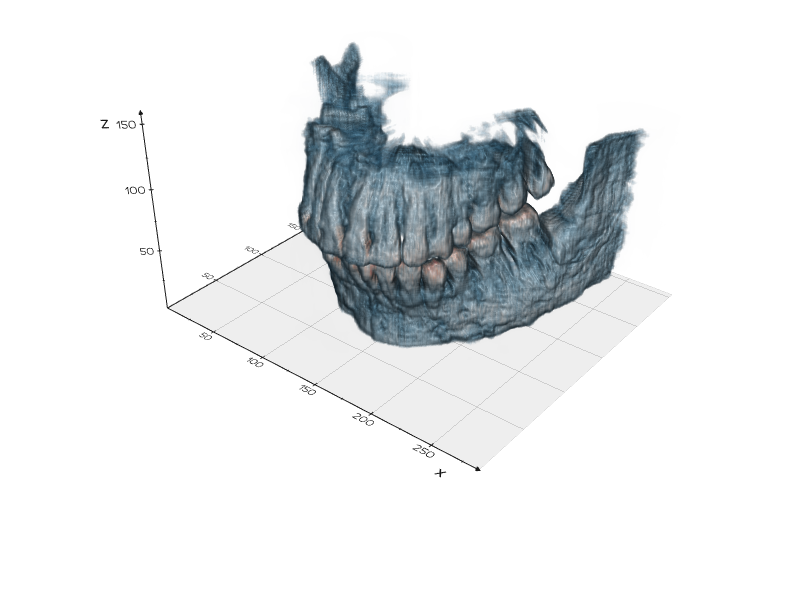

In [15]:

spline_start = interpolate_spline_from_control_points(control_points_init, num_points=576)
cbct_start = interpolate_cbct(generation_np, spline_start)
mpr_filename = f"CBCT_before_opt{case_id:03d}.nii.gz"
identity_affine = np.eye(4, dtype=np.float32)
save_nii(cbct_start, identity_affine, mpr_filename, output_dir)
vol = Volume(cbct_start, spacing=(1, 1, 1))
show(vol, axes=1, viewup='z', interactive=True)



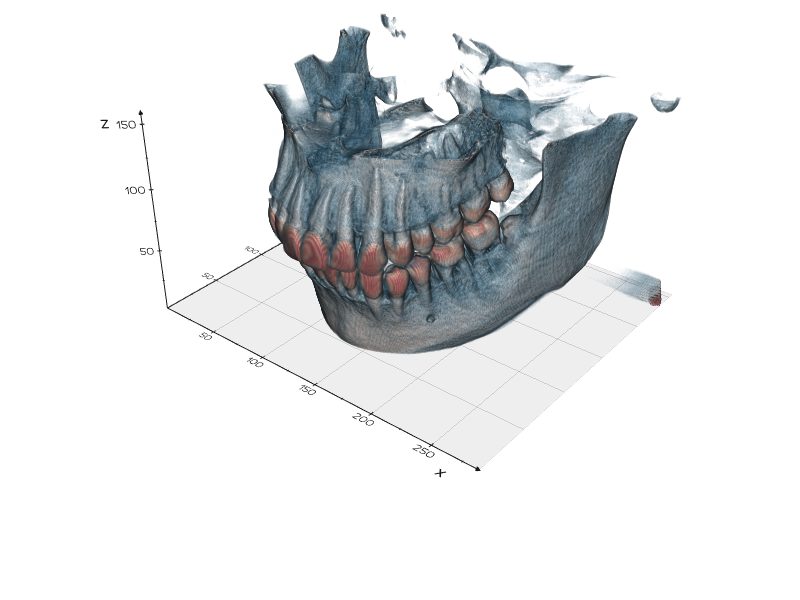

In [16]:
mpr_filename = f"cbct_true{case_id:03d}.nii.gz"
identity_affine = np.eye(4, dtype=np.float32)
save_nii(cbct_true, identity_affine, mpr_filename, output_dir)
vol = Volume(cbct_true, spacing=(1, 1, 1))
show(vol, axes=1, viewup='z', interactive=True)



In [17]:
psnr = get_psnr(cbct_start, cbct_true)
ssim = get_ssim(cbct_start, cbct_true)
dice = get_dice(cbct_start > -0.8, cbct_true > -0.5)

print("=== VALUTAZIONE CBCT ===")
print(f"PSNR : {psnr:.2f}")
print(f"SSIM : {ssim:.4f}")
print(f"Dice : {dice:.4f}")


print(f"[INFO] CBCT start  Minimo valore: {cbct_start.min():.2f}, Massimo valore: {cbct_start.max():.2f}")
print(f"[INFO] CBCT true Minimo valore: {cbct_true.min():.2f}, Massimo valore: {cbct_true.max():.2f}")



=== VALUTAZIONE CBCT ===
PSNR : 18.61
SSIM : 0.8072
Dice : 0.1794
[INFO] CBCT start  Minimo valore: -1.00, Massimo valore: 0.81
[INFO] CBCT true Minimo valore: 0.00, Massimo valore: 3999.00


inizializzazione del ciclo di ottimizzazione

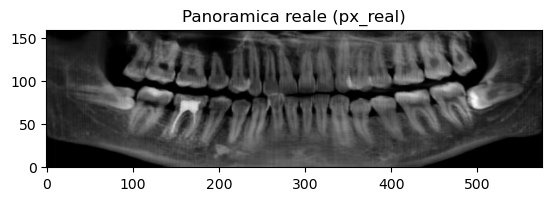

In [18]:
traj_start, _ = estimate_trajectory_by_dental_arch(cbct_start, spline_start)
proj_lines_start = traj_start.sample_projection_rays(sample_n=576, ray_length=100)
mpr_imgs_start = get_MPR_images_from_projection_rays(proj_lines_start, cbct_start, projection_distance=80)
px_start = get_projection_image_from_MPR_images(mpr_imgs_start).T


plt.imshow(px_start, cmap='gray',origin='lower') 
plt.title("Panoramica reale (px_real)")
plt.axis('on')
plt.show()

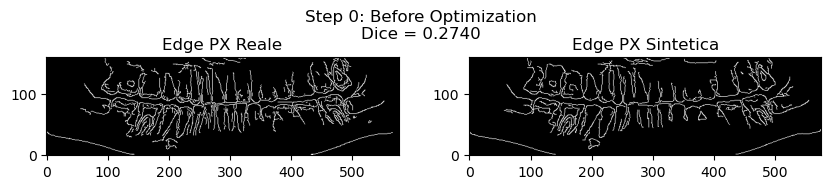

[INFO] Dice = 0.2740


0.27395964691025065

In [19]:
show_edge_comparison(px_start, px_real, title="Step 0: Before Optimization")

In [20]:
get_dice(px_start > 0, px_real > 0)

0.9572891327713436

In [21]:
print("[INFO] Ottimizzazione spline: inizio processo...")
start_time = time.time()
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
# minimizza la somma dei quadrati dei residui 


result = least_squares(
    fun=residuals_function,
    x0=params_init,
    args=(generation_np, px_real),
    method='trf',
    bounds=(lower_bounds, upper_bounds),
    max_nfev=100,
    verbose=2
)
elapsed = time.time() - start_time
formatted_time = str(timedelta(seconds=int(elapsed)))
print(f"[INFO] Ottimizzazione spline completata in {formatted_time} (hh:mm:ss)")


[INFO] Ottimizzazione spline: inizio processo...
[INFO] Step 1: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 2: Total Loss = 42.6437, NCC = 0.8838, EdgeLoss = 60.8752
[INFO] Step 3: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 4: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 5: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 6: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 7: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 8: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 9: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 10: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 11: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 12: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 13: Total Loss = 42.4015, NCC = 0.8841, EdgeLoss = 60.5293
[INFO] Step 14: Total Loss = 42.4015,

otteniamo un vettore di residui che guida l'ottimizzazione (Levenberg-Marquardt), permettendoci di deformare solo localmente la curva per minimizzare l'errore

[DEBUG] mpr.shape = (576, 80, 160)
[INFO] Ottimizzazione completata. Success: True, Msg: `xtol` termination condition is satisfied.
[INFO] Punti finali ottimizzati:
[[ 34.31999969 202.52404785]
 [ 52.90033741 164.17376812]
 [ 78.05672392 129.65899355]
 [ 98.17689028  91.96847221]
 [126.27552339  60.90531444]
 [167.84319849  59.79034844]
 [197.82141029  89.13518455]
 [216.82197692 127.40016409]
 [241.90181785 161.91777585]
 [254.99999997 199.9210968 ]]


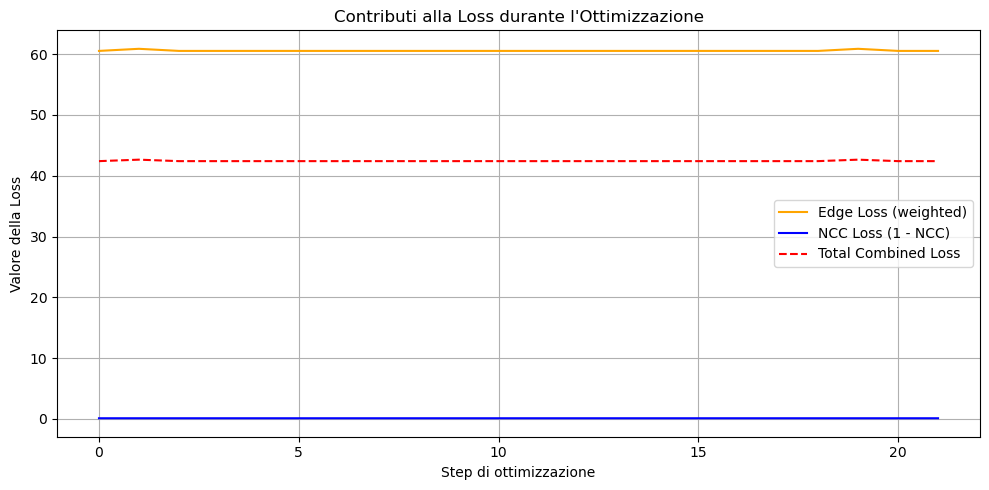

[DEBUG] mpr.shape = (576, 80, 160)


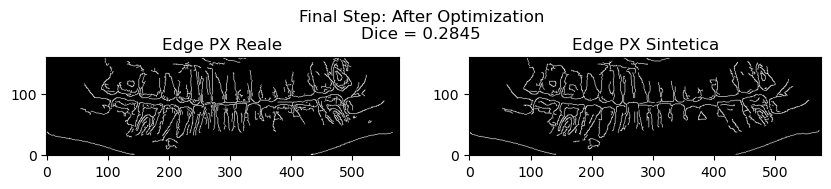

[INFO] Dice = 0.2845


0.284538692830919

In [22]:
print(f"[DEBUG] mpr.shape = {generation_np.shape}")  


print(f"[INFO] Ottimizzazione completata. Success: {result.success}, Msg: {result.message}")
final_control_points = result.x.reshape(-1, 2)
print("[INFO] Punti finali ottimizzati:")
print(final_control_points)

plot_loss_components(edge_loss_history, ncc_loss_history, loss_history)

spline_final = interpolate_spline_from_control_points(final_control_points, num_points=576)

#generation_np = np.transpose(generation_np, (1, 2, 0)) 
print(f"[DEBUG] mpr.shape = {generation_np.shape}")  
cbct_final = interpolate_cbct(generation_np, spline_final)

traj_final, _ = estimate_trajectory_by_dental_arch(cbct_final, spline_final)
proj_lines_final = traj_final.sample_projection_rays(sample_n=576, ray_length=100)
mpr_imgs_final = get_MPR_images_from_projection_rays(proj_lines_final, cbct_final, projection_distance=60)
#mpr_imgs_final = rotate(mpr_imgs_final, 180, axes=(1, 0), reshape=False)

px_final = get_projection_image_from_MPR_images(mpr_imgs_final).T

show_edge_comparison(px_final, px_real, title="Final Step: After Optimization")

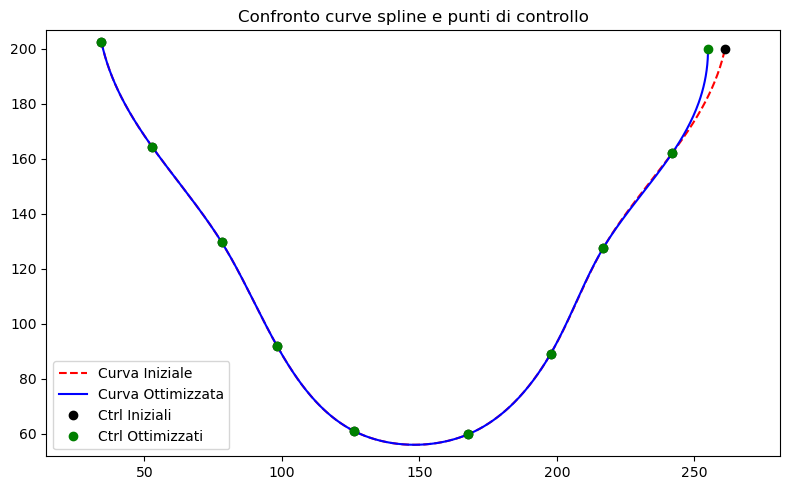


[INFO] Spostamento dei punti di controllo:
Punto di controllo 0: spostamento = 0.00 pixel
Punto di controllo 1: spostamento = 0.00 pixel
Punto di controllo 2: spostamento = 0.00 pixel
Punto di controllo 3: spostamento = 0.00 pixel
Punto di controllo 4: spostamento = 0.00 pixel
Punto di controllo 5: spostamento = 0.00 pixel
Punto di controllo 6: spostamento = 0.00 pixel
Punto di controllo 7: spostamento = 0.00 pixel
Punto di controllo 8: spostamento = 0.00 pixel
Punto di controllo 9: spostamento = 6.17 pixel


In [23]:
plt.figure(figsize=(8, 5))
plt.plot(spline_start[:, 0], spline_start[:, 1], 'r--', label="Curva Iniziale")
plt.plot(spline_final[:, 0], spline_final[:, 1], 'b-', label="Curva Ottimizzata")

plt.plot(control_points_init[:, 0], control_points_init[:, 1], 'ko', label="Ctrl Iniziali")
plt.plot(final_control_points[:, 0], final_control_points[:, 1], 'go', label="Ctrl Ottimizzati")

plt.legend()
plt.axis("equal")
plt.title("Confronto curve spline e punti di controllo")
plt.tight_layout()
plt.show()

print("\n[INFO] Spostamento dei punti di controllo:")
for i, (pt_old, pt_new) in enumerate(zip(control_points_init, final_control_points)):
    d = np.linalg.norm(pt_new - pt_old)
    print(f"Punto di controllo {i}: spostamento = {d:.2f} pixel")

[INFO] Volume CBCT finale salvato come: CBCT_case_001_final.nii.gz


(-0.5, 575.5, -0.5, 159.5)

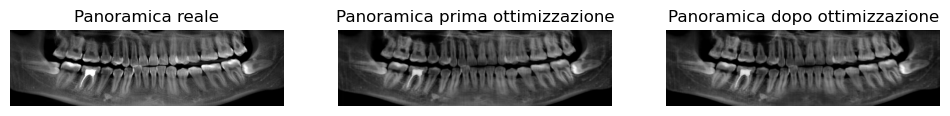

In [24]:
data_gen['PriorShape'] = spline_final
scipy.io.savemat(mat_path, data_gen)
#cbct_final = np.array((cbct_final + 1) * 2000, dtype=np.uint16)
#cbct_final = normalize_case(cbct_final)
#cbct_final = clamp_case(cbct_final, 4000)

ignore_slice_n = 15
cbct_final[:ignore_slice_n, :, :] = -1
cbct_final[-ignore_slice_n:, :, :] = -1
cbct_final = (cbct_final + 1.0) / 2.0 * 4000
cbct_final = np.clip(cbct_final, 0, 4000)  
cbct_final = clamp_case(cbct_final, 4000) 

cbct_final_name = f"CBCT_case_{case_id:03d}_final.nii.gz"
save_nii(cbct_final, identity_affine, cbct_final_name, output_dir)

print(f"[INFO] Volume CBCT finale salvato come: {cbct_final_name}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(px_real, cmap='gray',origin='lower')
plt.title("Panoramica reale")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(px_start, cmap='gray',origin='lower')
plt.title("Panoramica prima ottimizzazione")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(px_final, cmap='gray',origin='lower')
plt.title("Panoramica dopo ottimizzazione")
plt.axis("off")

Per valutare quanto l'ottimizzazione ha funzionato, se disponiamo del gold standard, confrontiamo le metriche di sovrapposizione fra il volume reale e i volumi ricostruiti prima e dopo l'ottimizzazione

=== VALUTAZIONE CBCT ===
PSNR : 18.61
SSIM : 0.8072
Dice : 0.1794
[INFO] CBCT start  Minimo valore: -1.00, Massimo valore: 0.81
[INFO] CBCT true Minimo valore: 0.00, Massimo valore: 3999.00
=== VALUTAZIONE CBCT ===
PSNR : 18.55
SSIM : 0.7102
Dice : 1.0000
CBCT final min/max: 0.0 / 3621.380090713501
CBCT true min/max: 0.0 / 3999.0


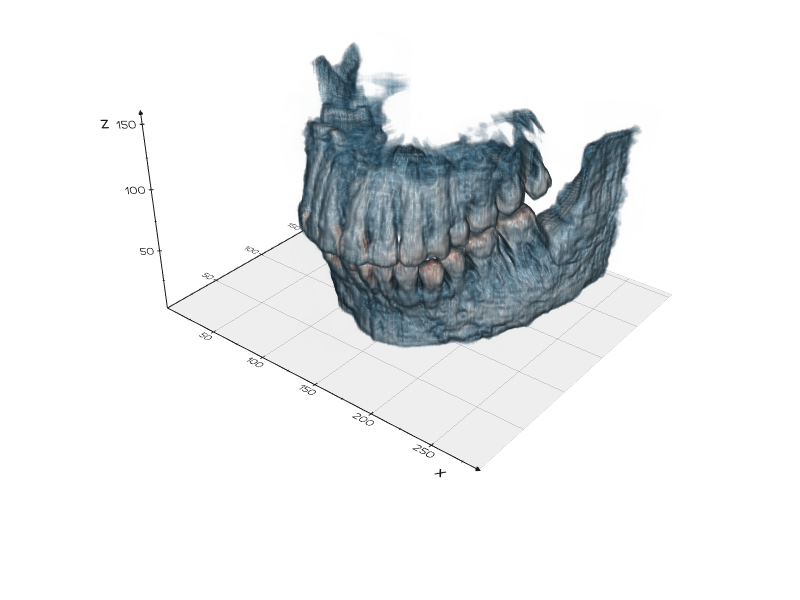

In [25]:
cbct_true = scipy.io.loadmat(base_path)['CBCT']

psnr = get_psnr(cbct_start, cbct_true)
ssim = get_ssim(cbct_start, cbct_true)
dice = get_dice(cbct_start > -0.8, cbct_true > -0.5)

print("=== VALUTAZIONE CBCT ===")
print(f"PSNR : {psnr:.2f}")
print(f"SSIM : {ssim:.4f}")
print(f"Dice : {dice:.4f}")


print(f"[INFO] CBCT start  Minimo valore: {cbct_start.min():.2f}, Massimo valore: {cbct_start.max():.2f}")
print(f"[INFO] CBCT true Minimo valore: {cbct_true.min():.2f}, Massimo valore: {cbct_true.max():.2f}")



psnr = get_psnr(cbct_final, cbct_true)
ssim = get_ssim(cbct_final, cbct_true)
dice = get_dice(cbct_final > -0.8, cbct_true > -0.5)

print("=== VALUTAZIONE CBCT ===")
print(f"PSNR : {psnr:.2f}")
print(f"SSIM : {ssim:.4f}")
print(f"Dice : {dice:.4f}")


print(f"CBCT final min/max: {cbct_final.min()} / {cbct_final.max()}")
print(f"CBCT true min/max: {cbct_true.min()} / {cbct_true.max()}")
vol = Volume(cbct_final, spacing=(1, 1, 1))
show(vol, axes=1, viewup='z', interactive=True)


Evaluation cbct reale-ricostruito
Non è necessario interpolare di nuovo la CBCT dopo l’ottimizzazione del ray tracing, perché il ray tracing agisce solo a valle per generare la px. 

In [26]:
data_gen = scipy.io.loadmat(mat_path)
#vol = Volume(cbct_reale, spacing=(1, 1, 1))
#show(vol, axes=1, viewup='z', interactive=True)


In [27]:
#ssim_func = SSIM(device=device) 
#ssim = ssim_func.eval_ssim(cbct_final, cbct_true)
#psnr = get_psnr(cbct_final, cbct_true)
#dice = get_dice(cbct_final > -0.5, cbct_true > -0.5)
#
#print("\n=== VALUTAZIONE CBCT ===")
#print(f"PSNR : {psnr:.2f}")
#print(f"SSIM : {ssim:.4f}")
#print(f"Dice : {dice:.4f}")


ora la curva spline rimane invariata e le trasformazioni vengono applicate solo ai parametri della proiezione (sorgente raggi, distanza, scala, ecc.). Questo rende il modello più coerente e fisiologicamente corretto, in quanto si separano le deformazioni locali (curva) dalle trasformazioni geometriche globali (sistema di proiezione).
si cerca di applicare trasformazioni globali (TX, TY, angolo, scala) 

i raggi vengono riposizionati nello spazio prima di essere usati per generare l’immagine panoramica, simulando effetti come inclinazione, spostamento o zoom del sistema RX virtuale.

In [28]:
#show_single_projection(spline_curve=spline_final, cbct_volume=cbct_final,
#  tx=0,ty=0, angle_deg=10,scale=1,proj_dist=60)

Minimizzare una funzione di costo tra: la panoramica simulata generata con ray tracing parametrizzato e la panoramica reale preprocessata.

In [29]:
loss_history = []
edge_loss_history = []
ncc_loss_history = []
iteration_counter = 0

def residuals_raytracing_params(params, spline_curve, cbct_volume, px_real):
    global iteration_counter
    iteration_counter += 1
    tx, ty, angle_deg, scale, proj_dist = params

    # Ray tracing con trasformazioni geometriche (non cambia la curva)
    px_sim = apply_raytracing_params(
        spline_curve, cbct_volume, tx=tx, ty=ty,angle_deg=angle_deg,
        scale=scale, proj_dist=proj_dist)

    # Calcolo edge
    edge_sim = cv2.Canny(to_uint8(px_sim), CANNY_LOW, CANNY_HIGH).astype(np.float32)
    edge_real = cv2.Canny(to_uint8(px_real), CANNY_LOW, CANNY_HIGH).astype(np.float32)
    edge_residual = edge_sim - edge_real

    # Maschera con pesi (più peso alla zona centrale)
    weights = np.ones_like(edge_sim)
    weights[30:120, 80:480] = 3.0 
    weighted_residual = (weights * edge_residual).flatten()

    # NCC (cross-correlazione tra immagini)
    ncc_score = normalized_cross_correlation(px_sim, px_real)
    ncc_residual = np.ones_like(weighted_residual) * (1 - ncc_score)

    # Combinazione pesata
    alpha = 0.7
    combined_residual = alpha * weighted_residual + (1 - alpha) * ncc_residual

    loss_edge = np.mean(np.abs(weighted_residual))          # differenza sui bordi (con pesi)
    loss_ncc = 1 - ncc_score                                 # somiglianza globale (1 - NCC)
    total_loss = np.mean(np.abs(combined_residual))         # combinazione pesata

    edge_loss_history.append(loss_edge)
    ncc_loss_history.append(loss_ncc)
    loss_history.append(total_loss)

    # === Stampa informativa a ogni iterazione ===
    print(f"[Iter {iteration_counter:02d}] TX: {tx:.2f} TY: {ty:.2f} Rot: {angle_deg:.2f}° "
        f"Scale: {scale:.3f} ProjDist: {proj_dist:.2f} → "
        f"Total Loss={total_loss:.4f}, Edge={loss_edge:.4f}, NCC Loss={loss_ncc:.4f}")

    return combined_residual


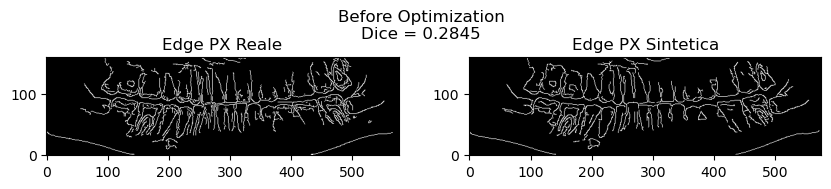

[INFO] Dice = 0.2845


c:\Users\angel\Desktop\ottim\preprocess\utils.py:206: RuntimeWarning:

overflow encountered in exp

C:\Users\angel\AppData\Local\Temp\ipykernel_10248\3704212238.py:168: RuntimeWarning:

invalid value encountered in subtract

c:\Users\angel\anaconda3\envs\tesi\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning:

invalid value encountered in subtract



[Iter 01] TX: 0.00 TY: 0.00 Rot: 0.00° Scale: 1.000 ProjDist: 60.00 → Total Loss=nan, Edge=45.3416, NCC Loss=nan


ValueError: Residuals are not finite in the initial point.

In [30]:
show_edge_comparison(px_final, px_real, title="Before Optimization")

params0 = [0, 0.0, 0, 1.0, 60.0]  # tx, ty, angle, scale, proj_dist
bounds = ([-20, -20, -30, 0.9, 40],   # lower bounds
          [20, 20, 30, 1.1, 80])      # upper bounds

result = least_squares(
    residuals_raytracing_params,
    x0=params0,
    bounds=bounds,
    args=(spline_final, cbct_final, px_real),
    method='trf',
    max_nfev=100,
    verbose=2
)

# Risultati ottimali
best_tx, best_ty, best_angle, best_scale, best_proj_dist = result.x
show_single_projection(
    spline_curve=spline_final,
    cbct_volume=cbct_final,
    tx=best_tx,
    ty=best_ty,
    angle_deg=best_angle,
    scale=best_scale,
    proj_dist=best_proj_dist,
    #title="Proiezione Ottimizzata"
)
print("\n=== PARAMETRI OTTIMIZZATI ===")
print(f"[TX        ]: {best_tx:.2f} px")
print(f"[TY        ]: {best_ty:.2f} px")
print(f"[Rotazione ]: {best_angle:.2f}°")
print(f"[Scala     ]: {best_scale:.3f}")
print(f"[ProjDist  ]: {best_proj_dist:.2f} mm")

px_optimized = apply_raytracing_params(
    spline_final, cbct_final,
    tx=best_tx, ty=best_ty,
    angle_deg=best_angle,
    scale=best_scale,
    proj_dist=best_proj_dist
)

show_edge_comparison(px_optimized, px_real, title="Confronto Dopo Ottimizzazione Ray Tracing")

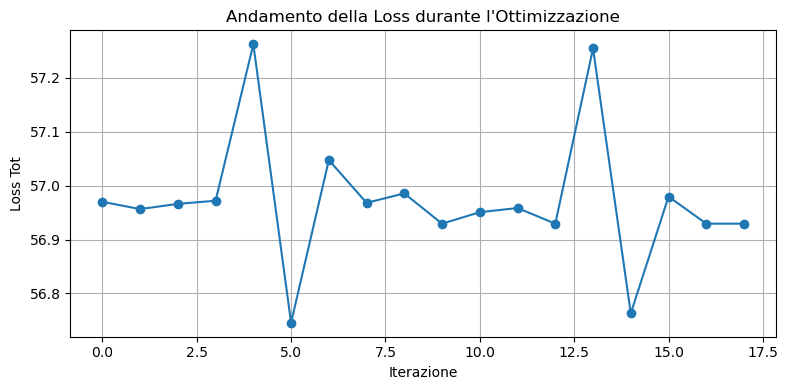

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Andamento della Loss durante l'Ottimizzazione")
plt.xlabel("Iterazione")
plt.ylabel("Loss Tot")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# tentativo di generare raggi proiettivi simulando una rotazione orbitale della sorgente RX attorno al paziente.
#def generate_orbital_rays(center_target, radius=800, angle_start=-30, angle_end=30, num_rays=576):
#    """
    
#    - center_target: np.array([x, y, z]) → centro verso cui puntano tutti i raggi
#    - radius: raggio della traiettoria orbitale
#    - angle_start, angle_end: range angolare in gradi (es. -30° a +30°)
#    - num_rays: numero totale di raggi da generare
#    """
#    rays = []
#    angles = np.deg2rad(np.linspace(angle_start, angle_end, num_rays))
#    for theta in angles:
#        origin = np.array([
#            center_target[0] + radius * np.cos(theta),
#            center_target[1] + radius * np.sin(theta),
#            center_target[2]
#        ])
#        direction = center_target - origin
#        direction /= np.linalg.norm(direction)
#usa Pitagora per normalizzare il vettore direzionale, cioè per farlo diventare un versore unitario. 
#        theta_xy = np.arctan2(direction[1], direction[0])  # Angolo nel piano XY
#        ray = ProjectionRay(center=Point(origin[0], origin[1]), theta=theta_xy, length=100)
#        rays.append(ray)
#    return rays
#
#center_target = np.array([cbct_final.shape[1] // 2, cbct_final.shape[0] // 2, 0])  # centro del volume in XY
#rays = generate_orbital_rays(center_target, radius=800, angle_start=-30, angle_end=30, num_rays=576)
#
#mpr = get_MPR_images_from_projection_rays(rays, cbct_final, projection_distance=60)
#px_sim = get_projection_image_from_MPR_images(mpr)
#
#
#plt.imshow(px_sim.T, cmap='gray')
#plt.title("Proiezione Orbitale (Simulazione RX)")
#plt.axis('off')
#plt.show()
#
##sorgente RX che si muove lungo un arco circolare attorno a un punto bersaglio center_target
## da chiarire le coordinare del centro del volume che non è centrato 